In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
from selenium import webdriver
import time
from selenium.webdriver.chrome.service import Service as ChromeService
import matplotlib.pyplot as plt

# chrono24.com scraper



1. Retrieve the specifics of specific reference
2. Retrieving the price history of specific references 

In [2]:
refs = ["326935", "326934"]

### Retrieve the page content

In [3]:
urls = []
for query in refs:
    url= "https://www.chrono24.com/search/index.htm?currencyId=USD&dosearch=true&maxAgeInDays=0&pageSize=60&query=" + query + "&redirectToSearchIndex=true&resultview=block&searchexplain=1&sortorder=15&usedOrNew=new"

    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    soup =soup.find("div", "article-item-container wt-search-result")

    for i in str(soup).split():
        if "href" in i:
            url = i.split('"')[1]
            urls.append("https://www.chrono24.com" + url)

### Create dataframe containing the specifics

In [4]:
dictionaries = []


for watch in urls:
    page = requests.get(watch)
    soup = BeautifulSoup(page.content, "html.parser")

    info=[]
    for i in soup.find_all("div", "col-xs-24 col-md-12"):
        element= i.text.replace(" ", "").split("\n")
        if element != "":
            info.append(element)

    info = [item for sublist in info for item in sublist if item != '' and item != "\r"][3:]

    dictionary = {}
    for i in range(0, len(info), 2):
        try:
            dictionary.update({info[i]: info[i+1]})
        except:
            pass
        
    dictionaries.append(dictionary)
    
data  = pd.DataFrame(dictionaries)[[ "Brand", "Model", "Referencenumber", "Movement", "Casematerial", "Braceletmaterial", "Yearofproduction", "Condition"]]
print(data)


   Brand        Model Referencenumber   Movement Casematerial  \
0  Rolex  Sky-Dweller          326935  Automatic     Rosegold   
1  Rolex  Sky-Dweller          326934  Automatic        Steel   

  Braceletmaterial Yearofproduction Condition  
0         Rosegold             2021       New  
1            Steel             2021    Unworn  


### Create dataframe of the reference's price history and plot it

In [ ]:
def retrieve_price_history(reference):
    time.sleep(1)
    
    url= "https://www.chrono24.com/search/index.htm?currencyId=USD&dosearch=true&maxAgeInDays=0&pageSize=60&query=" + ref + "&redirectToSearchIndex=true&resultview=block&searchexplain=1&sortorder=0&usedOrNew=new"
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")
    soup =soup.find("div", "article-item-container wt-search-result")

    urls = ["https://www.chrono24.com" + i.split('"')[1] for i in str(soup).split() if "href" in i]

    Id = str(urls[0]).split(".")[2].split("d")[-1:]

    api_url = "https://www.chrono24.com/api/watch/collection/item/chart/price.json?watchId={}&period=max".format(str(urls[0]).split(".")[2].split("d")[-1:][0])

    print(api_url)

    options = webdriver.ChromeOptions() 
    options.add_argument("user-data-dir=C:\\Users\\pietr\\AppData\\Local\\Google\\Chrome\\User Data") #Path to your chrome profile
    options.add_argument('--profile-directory=Default')
    options.add_argument('--headless')
    options.add_argument('--no-sandbox')
    options.add_argument('--disable-dev-shm-usage')

    driver = webdriver.Chrome(executable_path = 'drivers\chromedriver.exe', options= options)

    driver.get(api_url)

    html = driver.page_source
    soup = BeautifulSoup(html,'lxml')


    data = soup.text.split("coordinatesPostPurchase")[1].split(",")


    data = [i.replace('"value"', "").replace("}", "").replace(":", "").replace('"', "").replace("]", "") for i in data if "value" in i]
    data = [[data[i], data[i+1], data[i+2], data[i+3]] for i in range(0, len(data), 4)]


    df = pd.DataFrame(data)
    df = df.rename(columns={0: "date", 1: "upper", 2:"average", 3:"lower"})
    df['date'] = pd.to_datetime(df['date'])
    df['average'] = pd.to_numeric(df['average'])
    df['upper'] = pd.to_numeric(df['upper'])
    df['lower'] = pd.to_numeric(df['lower'])

    df =df.set_index('date')
    plt.figure(figsize = [15, 8])
    plt.style.use('ggplot')

    plt.plot(df['average'], label = 'average')
    plt.plot(df['upper'], label = 'upper')
    plt.plot(df['lower'], label = 'lower')
    plt.title("Price Watches ref. " + reference)
    plt.ylabel("Price")
    plt.xlabel("Year")
    plt.legend()
    plt.show()
    return df

326935
https://www.chrono24.com/api/watch/collection/item/chart/price.json?watchId=12078714&period=max


C:\Users\pietr\AppData\Local\Temp\ipykernel_20208\383949958.py:24: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path = 'drivers\chromedriver.exe', options= options)


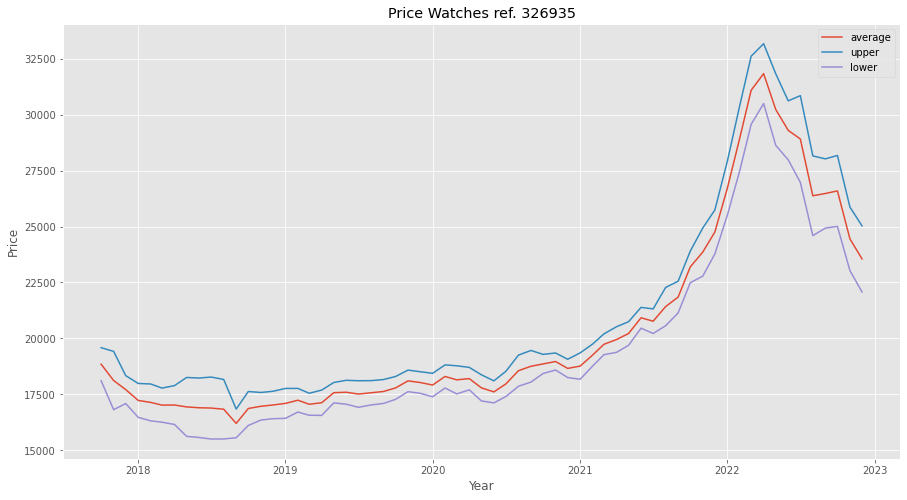

326934
https://www.chrono24.com/api/watch/collection/item/chart/price.json?watchId=19768985&period=max


C:\Users\pietr\AppData\Local\Temp\ipykernel_20208\383949958.py:24: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(executable_path = 'drivers\chromedriver.exe', options= options)


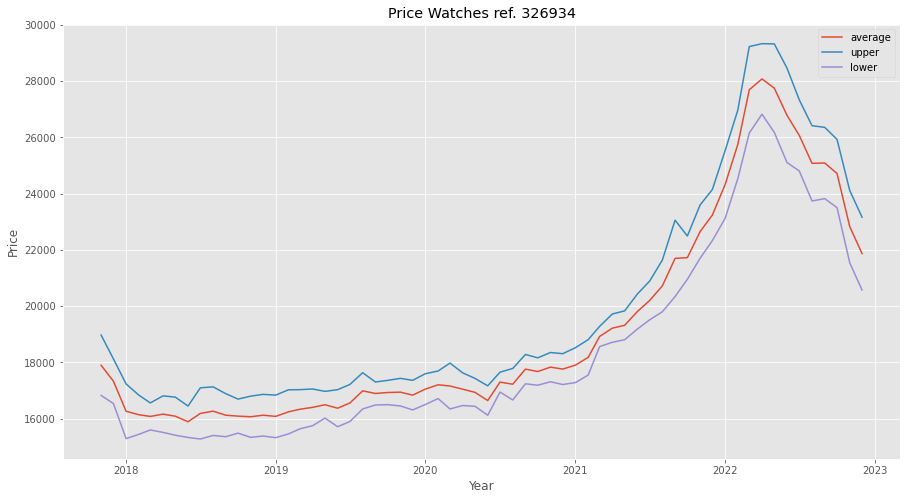

In [11]:
for i in refs:
    print(i)
    time.sleep(1)
    retrieve_price_history(i)